In [1]:
# Project configuration - use absolute paths
from pathlib import Path
PROJECT_ROOT = Path("/home/doshlom4/work/final_project")
print(f"Project root: {PROJECT_ROOT}")

Project root: /home/doshlom4/work/final_project


In [2]:
import scipy
import torch
from diffusers import DDPMScheduler
from tqdm import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers.models.unets.unet_2d_condition import UNet2DConditionModel
import os
import glob
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from scipy import linalg
from torchvision.datasets import MNIST
import torch.nn.functional as F
from torchvision.models import inception_v3
import numpy as np

/home/doshlom4/work/conda/envs/shlomid_conda_12_11_2025/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import custom UNet model from models directory
import sys
sys.path.insert(0, str(PROJECT_ROOT))
from models.custom_unet import CustomUNet2DConditionModel, load_unet_from_latest_checkpoint

# Load model (will be populated with checkpoint weights in next cell)
unet = CustomUNet2DConditionModel().to(device)

In [4]:
# vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Freeze VAE and text encoder
# vae.requires_grad_(False)
## set requires_grad_ to true so that the text_enocder aka CLIP model is also trained.
text_encoder.requires_grad_(False)
# tokenizer.requires_grad_(False)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [5]:
tokenizer.model_max_length ## 77

77

In [6]:
TOKENIZER_MAX_LENGTH = 8
captions_sample = ['"A handwritten digit 1']
text_input = tokenizer(captions_sample, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
text_encoder(text_input.input_ids.to(device))[0].shape

## the following output is the size of the text embedding for one text prompt.

torch.Size([1, 8, 512])

In [7]:
num_of_params = sum([p.numel() for p in unet.parameters()])
print("Number of trainable parameters in the model: " + str(f"{num_of_params:,}"))

Number of trainable parameters in the model: 3,140,385


In [8]:
# Load checkpoint using utility function
unet, checkpoint = load_unet_from_latest_checkpoint(device)

Loading checkpoint: /home/doshlom4/work/final_project/checkpoints/train1_unet_checkpoint_epoch_20.pt
Loaded model from epoch 20


## Basic Generation (Without CFG)

This generation function does **not** use Classifier-Free Guidance (CFG). It performs standard conditional generation where the model directly follows the text prompt without any guidance scaling or unconditional mixing.

- **Effective guidance scale**: w=1 (implicit - full text conditioning)
- **No unconditional component**: Model only uses the text embedding
- **Simpler but less controllable**: Cannot adjust the strength of text-image alignment

For CFG with adjustable guidance scales, see the next section.

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 40.71it/s]

torch.Size([1, 1, 28, 28])


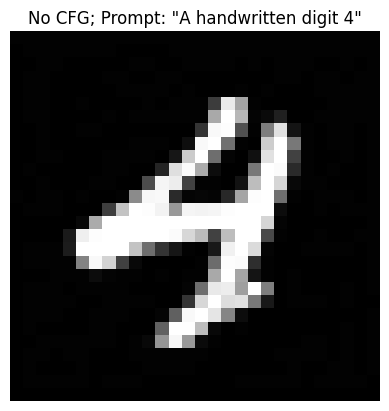

In [14]:
# Set models to evaluation mode
# vae.eval()
text_encoder.eval()
unet.eval()

# Inference parameters
num_inference_steps = 50
# guidance_scale = 100

@torch.no_grad()
def generate_image(prompt):
    # Tokenize and encode the text prompt
    text_input = tokenizer(prompt, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

    # Initialize latents / create noisy image.
    # IMPORTANT: do NOT reset the RNG seed inside this function.
    latents = torch.randn((1, unet.config.in_channels, 28, 28), device=device)

    # Denoise scheduler
    scheduler = DDPMScheduler(beta_schedule="squaredcos_cap_v2", num_train_timesteps=1000)
    scheduler.set_timesteps(num_inference_steps)

    # Denoising loop
    for t in tqdm(scheduler.timesteps):
        # Prepare latent model input
        latent_model_input = scheduler.scale_model_input(latents, t)

        # Predict noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Compute previous noisy sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # # Decode latents to image
    # latents = 1 / 0.18215 * latents
    # image = vae.decode(latents).sample
    image = latents
    print(image.shape)
    # Post-process image ## i.e reverse the normalization
    image = (image / 2 + 0.5).clamp(0, 1)
    return image

# Generate an image
prompt = "A handwritten digit 4"
generated_image = generate_image(prompt)

# Display or save the image
image = generated_image[0]  # Remove the extra dimension
image = image.squeeze(0)
image = image.detach().cpu().numpy()  # Remove batch dimension
image = (image * 255).round().astype("uint8")
plt.imshow(image, cmap='gray')  # Display as grayscale image
plt.title(f'No CFG; Prompt: "{prompt}"', fontsize=12)
plt.axis('off')
plt.show()

100%|██████████| 50/50 [00:01<00:00, 40.44it/s]


torch.Size([1, 1, 28, 28])


100%|██████████| 50/50 [00:01<00:00, 41.44it/s]


torch.Size([1, 1, 28, 28])


100%|██████████| 50/50 [00:01<00:00, 40.78it/s]


torch.Size([1, 1, 28, 28])


100%|██████████| 50/50 [00:01<00:00, 41.05it/s]


torch.Size([1, 1, 28, 28])


100%|██████████| 50/50 [00:01<00:00, 41.10it/s]


torch.Size([1, 1, 28, 28])


100%|██████████| 50/50 [00:01<00:00, 41.52it/s]


torch.Size([1, 1, 28, 28])


100%|██████████| 50/50 [00:01<00:00, 41.27it/s]


torch.Size([1, 1, 28, 28])


100%|██████████| 50/50 [00:01<00:00, 41.25it/s]


torch.Size([1, 1, 28, 28])


100%|██████████| 50/50 [00:01<00:00, 41.37it/s]


torch.Size([1, 1, 28, 28])


100%|██████████| 50/50 [00:01<00:00, 41.27it/s]


torch.Size([1, 1, 28, 28])


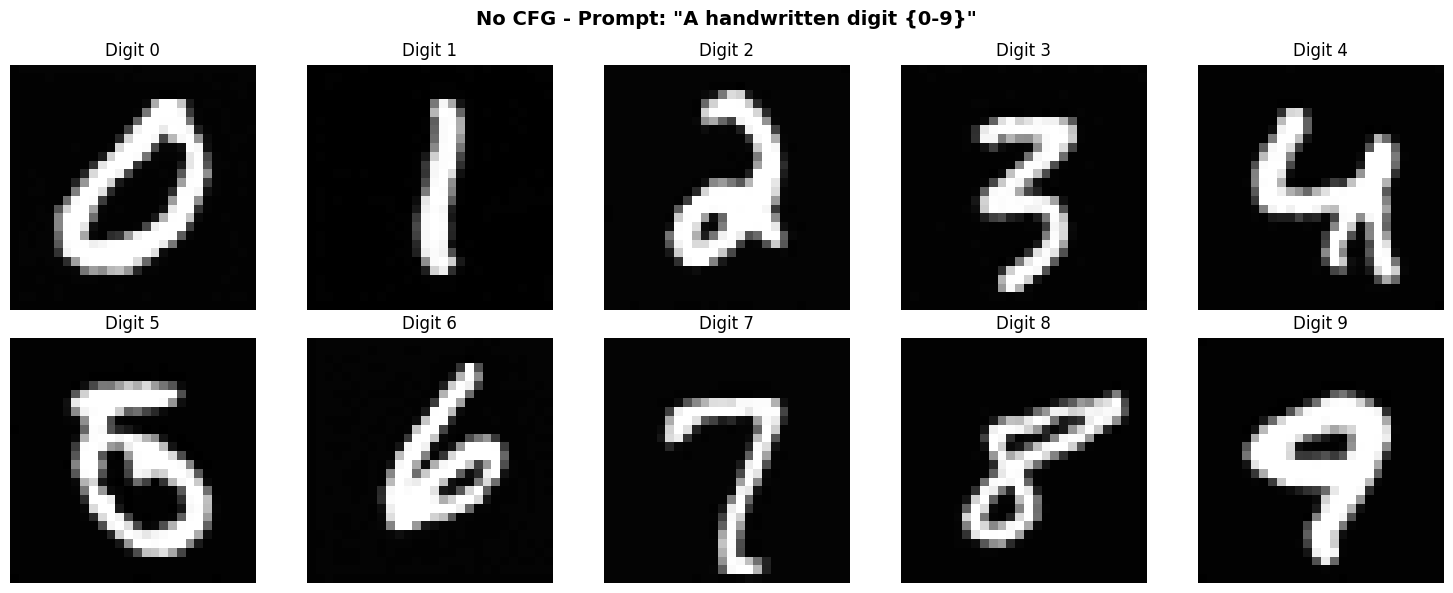

In [16]:
# Generate images for all digits (0-9) without CFG
digits = list(range(10))  # 0 through 9

# Initialize a figure with a grid: 2 rows x 5 columns
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
axs = axs.flatten()  # Flatten to easily iterate

# Generate images for each digit
for idx, digit in enumerate(digits):
    # Generate an image
    prompt = f"A handwritten digit {digit}"
    generated_image = generate_image(prompt)
    
    # Display or save the image
    image = generated_image[0].squeeze(0).detach().cpu().numpy()
    image = (image * 255).round().astype("uint8")
    
    # Display the image in the current subplot
    axs[idx].imshow(image, cmap='gray')
    axs[idx].set_title(f'Digit {digit}', fontsize=12)
    axs[idx].axis('off')

# Add overall figure title
fig.suptitle('No CFG - Prompt: "A handwritten digit {0-9}"', fontsize=14, fontweight='bold', y=0.98)

# Layout so plots do not overlap
fig.tight_layout()

# Display the plot
plt.show()

## Generation with Classifier-Free Guidance (CFG)

This generation function implements **Classifier-Free Guidance (CFG)**, which provides stronger control over text-image alignment compared to the previous basic generation.

### Key Differences from Previous Cell:

1. **Dual Embeddings**: Creates both conditional (text prompt) and unconditional (empty string "") embeddings
2. **Guidance Scale Parameter**: Accepts `guidance_scale` (w) to control the strength of text conditioning
3. **CFG Formula**: Combines both predictions using: `noise_pred = noise_pred_uncond + w * (noise_pred_text - noise_pred_uncond)`
4. **Adjustable Control**: Higher w values → stronger adherence to text prompt; w=0 → unconditional generation

### Benefits of CFG:
- **Better text-image alignment**: Produces images that match the prompt more closely
- **Tunable strength**: Can adjust guidance scale to balance quality vs. prompt adherence
- **More consistent results**: Reduces artifacts and improves image quality at appropriate guidance scales

100%|██████████| 50/50 [00:01<00:00, 39.72it/s]


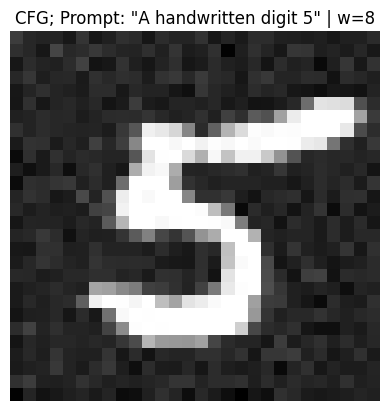

In [17]:
# Set models to evaluation mode
# vae.eval()
# text_encoder.eval()  # already set earlier
unet.eval()

# Inference parameters
num_inference_steps = 50

@torch.no_grad()
def generate_image(prompt, guidance_scale, num_images=1):
    # Tokenize and encode the text prompt
    text_input = tokenizer(prompt, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

    # Prepare unconditioned embeddings for classifier free guidance
    uncond_input = tokenizer([""] * num_images, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, return_tensors="pt")
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

    # Concatenate text embeddings with unconditional embeddings
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Initialize latents.
    # IMPORTANT: do NOT reset the RNG seed inside this function.
    latents = torch.randn((num_images, unet.config.in_channels, 28, 28), device=device)

    # Denoise scheduler
    scheduler = DDPMScheduler(beta_schedule="squaredcos_cap_v2", num_train_timesteps=1000)
    scheduler.set_timesteps(num_inference_steps)

    for t in tqdm(scheduler.timesteps):
        # Expand latents for classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # Predict noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Compute previous noisy sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # Decode latents to image (pixel-space, no VAE)
    image = (latents / 2 + 0.5).clamp(0, 1)
    return image

# Quick demo
prompt = "A handwritten digit 5"
guidance_scale = 8
# For reproducible demos, set the seed ONCE here (not inside generate_image)
torch.manual_seed(422)
generated_images = generate_image(prompt, guidance_scale=guidance_scale)

# Display or save the image
image = generated_images[0].squeeze(0).detach().cpu().numpy()
image = (image * 255).round().astype("uint8")
plt.imshow(image, cmap='gray')
plt.title(f'CFG; Prompt: "{prompt}" | w={guidance_scale}', fontsize=12)
plt.axis('off')
plt.show()

## Matrix Visualization: All Digits With CFG

This visualization generates images for all digits (0-9) using CFG with a fixed guidance scale. This demonstrates how CFG improves text-image alignment and generation quality compared to the non-CFG baseline.

100%|██████████| 50/50 [00:01<00:00, 41.31it/s]


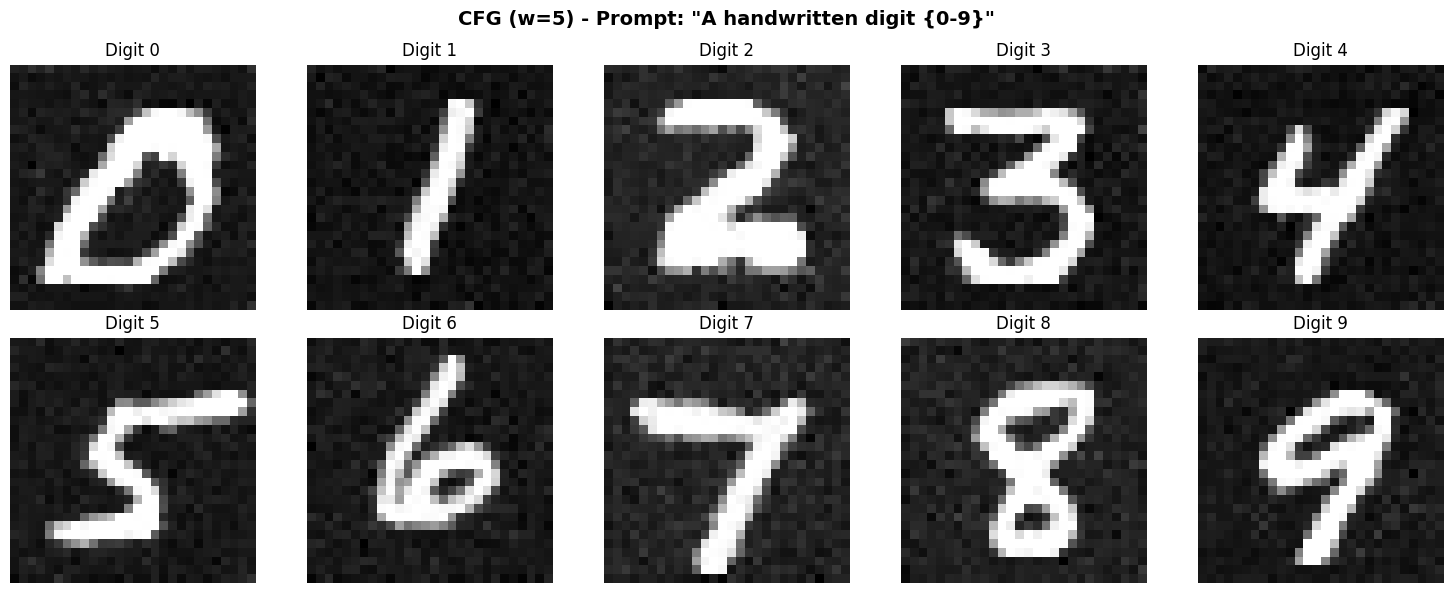

In [18]:
# Generate images for all digits (0-9) with CFG
digits = list(range(10))  # 0 through 9
guidance_scale = 5

# Initialize a figure with a grid: 2 rows x 5 columns
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
axs = axs.flatten()  # Flatten to easily iterate

# Generate images for each digit
for idx, digit in enumerate(digits):
    # Generate an image
    prompt = f"A handwritten digit {digit}"
    generated_image = generate_image(prompt, guidance_scale=guidance_scale)
    
    # Display or save the image
    image = generated_image[0].squeeze(0).detach().cpu().numpy()
    image = (image * 255).round().astype("uint8")
    
    # Display the image in the current subplot
    axs[idx].imshow(image, cmap='gray')
    axs[idx].set_title(f'Digit {digit}', fontsize=12)
    axs[idx].axis('off')

# Add overall figure title
fig.suptitle(f'CFG (w={guidance_scale}) - Prompt: "A handwritten digit {{0-9}}"', fontsize=14, fontweight='bold', y=0.98)

# Layout so plots do not overlap
fig.tight_layout()

# Display the plot
plt.show()